# 🎬 Movies recomendation using Content-Based and Collaborative Filtering
---

## 1. Recommendation Systems

**Recommendation Systems (RS)** are a subclass of information filtering system that provide suggestions for items that are most pertinent to a particular user. Typically, the suggestions refer to various decision-making processes, such as what product to purchase, what music to listen to, or what online news to read. Recommender systems are particularly useful when an individual needs to choose an item from a potentially overwhelming number of items that a service may offer. There are many types of RS:
   1. Content-Based Filtering: Recommendations based on product attributes and it's similarities;
   2. Collaborative Filtering (CF): Uses 'wisdom of the crowd' to match recommendations to users;
       - Memory-based CF: Relies on historical data to fit recommendations
           - User-based filtering: Based on users with similar tastes.
           - Item-based filtering: Based on items liked by similar users. 
       - Model-based CF: Finds underlying patterns inside the data to predict best recommendations.

## 2. Importing Data


We begin the project importing libraries and files to work with. The Archives used here comprises data from many user evaluations of movie titles, from 1 (bad) to 5 (excelent) stars. 
Before starting to look into the data, we have to combine two archives to translate `movie_id` into the `movie title`.Then, we can perform an explanatory analysis within the DF. 


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [52]:
movies = pd.read_csv('Refactored_Py_DS_ML_Bootcamp-master/19-Recommender-Systems/u.data',
                     sep = '\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [3]:
movies.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [53]:
titles = pd.read_csv('Refactored_Py_DS_ML_Bootcamp-master/19-Recommender-Systems/Movie_Id_Titles')

In [5]:
titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
df = pd.merge(movies, titles, on='item_id', how = 'inner')

In [7]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100003 non-null  int64 
 1   item_id    100003 non-null  int64 
 2   rating     100003 non-null  int64 
 3   timestamp  100003 non-null  int64 
 4   title      100003 non-null  object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB



A quick look shows us that our data file contains ~100,000 not null registers of user-movie ratings. Let's follow the process with EDA: 


## 3. EDA

Here we search for insights within the data. Let's check for data distributions, aggregate informations and engineer features to analyze, before perform the first recommendation system.

In [9]:
n_titles = df['title'].nunique()
n_users = df['user_id'].nunique()

print('movies: ',n_titles)
print('users: ', n_users)

movies:  1664
users:  944


<AxesSubplot:xlabel='rating', ylabel='Count'>

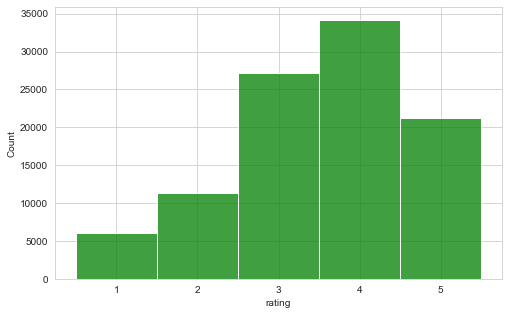

In [11]:
#checking how ratings are distributed in DF:
plt.figure(figsize=(8,5))
sns.set_style('whitegrid')
sns.histplot(data = df, x = 'rating', color = 'green', discrete = True)

In [15]:
#agregating relevant information by the title
ByTitle = df.groupby('title')['rating'].agg([len, np.mean, np.std])

In [16]:
#To ease understanding, we rename the columns
ByTitle.rename(columns = {'len': 'num of rates','mean':'rating', 'std':'rate_std'}, inplace = True)

# Quick look to new data
ByTitle[ByTitle['num of rates'] >= 5].sort_values('rating', ascending = False).head()

,num of rates,rating,rate_std
title,,,
Pather Panchali (1955),8,4.625000,0.517549
"Close Shave, A (1995)",112,4.491071,0.771047
Schindler's List (1993),298,4.466443,0.829109
"Wrong Trousers, The (1993)",118,4.466102,0.823607
Casablanca (1942),243,4.456790,0.728114


<function matplotlib.pyplot.savefig(*args, **kwargs)>

<Figure size 1152x720 with 0 Axes>

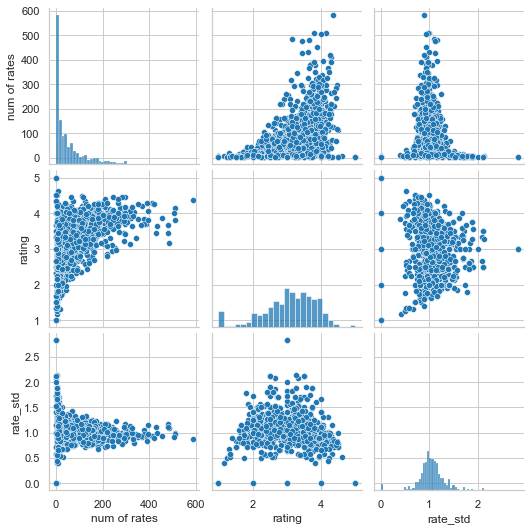

In [85]:
# Can we see any correlations inside this data? 
plt.figure(figsize=(16,10))
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.pairplot(ByTitle)

To summarize:
 - Higher average ratings tends to have more views. That makes sense, since it is much more likely we recommend a movie we like, than one we dislike. Also, the more it is seen the least sd it has. We can assume that beyond 100 people the ratings deviation stays on average bellow 1.5 points.
 - For the diagonal histograms, the rating appears to behave normally around 3 stars rating, wich makes sense. Also, usually they stay between 0 to 100 ratings.

## 4. Content-based systems

For this model, we build a User-Item Matrix with every user rating to every movie (or else, NaNs). We choose a movie that might been a blockbuster (has many reviews), and build a recommendation for it.

In [10]:
UI_mat = df.pivot_table(index = 'user_id', columns='title', values = 'rating')

In [11]:
UI_mat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='title'>

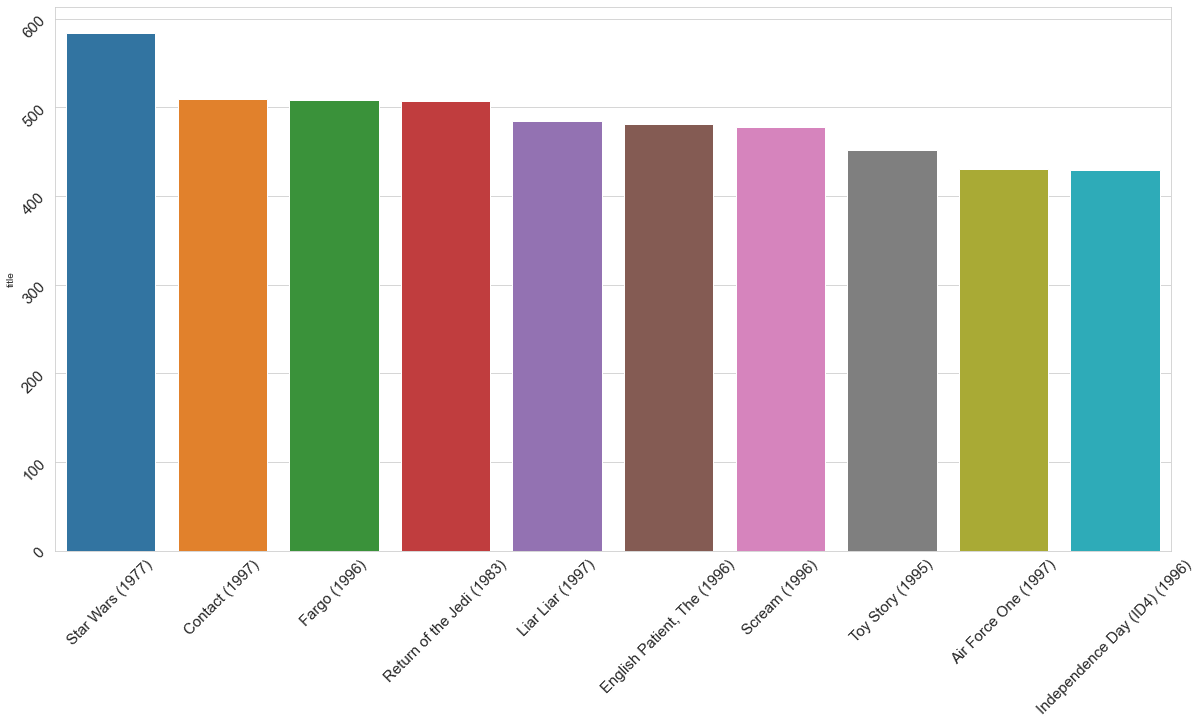

In [19]:
rates = pd.DataFrame(df['title'].value_counts().sort_values(ascending = False).head(10))

plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15, labelrotation = 45)
plt.ylabel('num of rates')
sns.barplot(data = rates, x = rates.index,
            y = 'title')


In [12]:
#selecting Toy Story (1995) as to recommend

TS_rates = UI_mat['Toy Story (1995)']
similarTo_TS = UI_mat.corrwith(TS_rates)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [13]:
cor_TS = pd.DataFrame(similarTo_TS, columns = ['correl'])
cor_TS.sort_values('correl',ascending = False)

,correl
title,
"Scarlet Letter, The (1995)",1.0
"Substance of Fire, The (1996)",1.0
"Stranger, The (1994)",1.0
"Wooden Man's Bride, The (Wu Kui) (1994)",1.0
"Newton Boys, The (1998)",1.0
...,...
"Woman in Question, The (1950)",NaN
Wonderland (1997),NaN
Yankee Zulu (1994),NaN


In [17]:
#since the index are the movie names, we can append num of rates from ByTitle DF

cor_TS['num of rates'] = pd.DataFrame(ByTitle['num of rates'])
cor_TS[cor_TS['num of rates'] >= 25].sort_values('correl', ascending = False)['correl'].head(10)

title
Toy Story (1995)                       1.000000
Transformers: The Movie, The (1986)    0.753673
Mouse Hunt (1997)                      0.736826
Farewell My Concubine (1993)           0.672918
Paris Is Burning (1990)                0.668410
Fallen (1998)                          0.654585
187 (1997)                             0.651857
Raise the Red Lantern (1991)           0.641535
Eddie (1996)                           0.623460
Associate, The (1996)                  0.620767
Name: correl, dtype: float64

This is a list of the 10th most likely movies to Toystory. We can simplify this process using a function that prints a list of most similar movies according to its name:

In [18]:
def CBsys(Mov_title, UImat, movie_rates_count, minViews):
    ''' Doc:
    Mov_title: str, Name of the movie as in User Item matrix
    ---
    UImat: User-Item Matrix (movies in column)
    ---
    movie_rates_count: pandas series with the num of rates of each movie
    ---
    minViews: the minimum number of reviews (ratings) before calculating corelation
    '''
    myMov = UImat[Mov_title]
    correl = pd.DataFrame(UImat.corrwith(myMov), columns = ['cor'])
    correl['views'] = pd.DataFrame(movie_rates_count)
    print(correl[(correl['views']>= minViews)].sort_values('cor', ascending = False).head(10))

#testing for Air Force One (1997)
CBsys('Air Force One (1997)', UI_mat, ByTitle['num of rates'], 20)
    

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


                                              cor  views
title                                                   
Air Force One (1997)                     1.000000    431
House of the Spirits, The (1993)         0.774597     24
Houseguest (1994)                        0.774597     24
Black Sheep (1996)                       0.766259     55
Little Buddha (1993)                     0.746729     22
Copycat (1995)                           0.711744     86
Higher Learning (1995)                   0.696826     30
Associate, The (1996)                    0.696300     41
It's My Party (1995)                     0.689100     21
Ma vie en rose (My Life in Pink) (1997)  0.681221     20


## 5. Collaborative Filtering
---


### 5.1 Model Based CF

This system finds underlying patterns in data as latent variables, and uses them to predict how any user is expected to rate an item.


To prepare the model, we need to create user-item matrices for train and test. First, we fill both matrices with zeros for every client (for the rows) and product (for columns). Then, we use the pandas `intertuples()` function to replace the corresponding values with rates from the dataframe sample (both for trainning and test data). 


After we have built the train and test matrices, we will rely on a technique called **matrix factorization (MF)**, which can restructure the  user-item matrix into low-rank structure, and  represents the matrix as the multiplication of two low-rank matrices (where the rows contain the latent vector). We fit this matrix to approximate the original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

In [57]:
df2 = pd.merge(movies, titles, on= 'item_id')
n_users = df2['user_id'].nunique()
n_titles = df2['item_id'].nunique()

In [58]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df2,
                                         test_size = 0.2,
                                         random_state=101)

In [60]:
#creating user-item matrices

#train
train_data_matrix = np.zeros((n_users, n_titles))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

#test
test_data_matrix = np.zeros((n_users, n_titles))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

#### 5.1.1 SVD

A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborative Filtering can be formulated by approximating a matrix `X` by using singular value decomposition. 


The general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Elements on the diagnoal in `S` are known as *singular values of `X`*. 


Matrix *`X`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space.

Now we can make predictions by taking the dot product of *`U`*, *`S`* and *`V^T`*.


In [61]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [62]:
u, s, vt = svds(train_data_matrix, k = 5)
s_diag = np.diag(s)

pred_matrix = np.dot(np.dot(u, s_diag), vt)

To evaluate this model, we need to flatten the prediction matrix and the test matrix into 1D-arrays, and compare how similar they are. To do so, we also need to drop the values with no evaluations in the test matrix, therefore, the zeros.

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#To calculate the model precision, we need to flatten the matrix into a 1D dimention and compare to the values in the test matrix which has been evaluated!
MSE = mean_squared_error(pred_matrix[test_data_matrix.nonzero()].flatten(),
                         test_data_matrix[test_data_matrix.nonzero()].flatten())

RMSE = sqrt(MSE)

#Lastly, let's print the results:
print(f'MSE is: {MSE:.2f}', )
print(f'RMSE is: {RMSE:.2f} ')

MSE is: 7.19
RMSE is: 2.68 


Considering the results above, we expect a root squared difference of, on average, 2.68 from the real value. We might as well try to group products by genre, or decade of production, to enhance the model precision. 

### 5.2 Memory-Based CF

Memory-Based Collaborative Filtering approaches can be divided into two main sections:

 - *User-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

 - *Item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 
 
Here we choose **User-item filtering** to predict movie rates. 

For the model assessment, we use a distance metric to calculate the similarity between users.

A distance metric commonly used in recommender systems is *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors. 
Cosine similiarity for users *a* and *m* can be calculated using the formula below, where you take dot product of  the user vector *$u_k$* and the user vector *$u_a$* and divide it by multiplication of the Euclidean lengths of the vectors.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

In [78]:
from sklearn.metrics import pairwise_distances

u_sim = pairwise_distances(train_data_matrix, metric ='cosine')

Next, we can use the metric to make predictions. We can make a prediction by applying following formula for user-based CF:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

Imagine the similarity between users *k* and *a* as weights that are multiplied by the ratings of a similar user *a* (corrected for the average rating of that user). Before applying the formula, we need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict. 

The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. 



In [83]:
mean_rate = train_data_matrix.mean(axis=1)

#to calculate the diff between current value and mean, we need to transform the mean to the same format as the matrix
rate_diff = (train_data_matrix - mean_rate[:,np.newaxis])

#use the above similarity to calculate the formula
pred = mean_rate[:,np.newaxis] +(u_sim.dot(rate_diff) / np.array([np.abs(u_sim).sum(axis = 1)]).T)

#EVALUATION
score = sqrt(mean_squared_error(pred[test_data_matrix.nonzero()].flatten(), test_data_matrix[test_data_matrix.nonzero()].flatten()))

print(f'RMSE for the memory-based CF:\n {score:.2f}')

RMSE for the memory-based CF:
 3.09


## 6. Conclusion
---

To conclude, we can assure that every **Recommending System** has its pros and couns, but they clearly can suit better accordingly with the problem and data available. 
Collaborative Filtering usually performs better, but requires higher computational capacity (and sometimes more data). In this case, the model-based with SVD matrix factorization had a better performance in terms of RMSE than the Memory-based with cosine similarity.
The content-based is simpler, though it cannot be measured and is less likely to overcome the former ones.
